# Time series datasets
This tutorial demonstrates how to use CellRank's interface to [Waddington OT (WOT)](https://broadinstitute.github.io/wot/) to work with time-series scRNA-seq data <cite data-cite="schiebinger:19">Schiebinger et al., Cell 2019</cite>. The interface is constructed via an [external kernel](https://cellrank.readthedocs.io/en/stable/external_api.html). In CellRank, we call everyting that computes a cell-cell transition matrix a kernel, see our [Kernels and estimators tutorial](https://cellrank.readthedocs.io/en/stable/kernels_and_estimators.html). An external kernel wraps around another method (like Waddington OT) so that you can use it from within CellRank, through the usual API. If you have your own method that you would like to integrate as an external kernel in CellRank, see our [Creating a new kernel tutorial](https://cellrank.readthedocs.io/en/stable/creating_new_kernel.html). 

We'll demonstrate this using the original data from the WOT publication <cite data-cite="schiebinger:19">Schiebinger et al., Cell 2019</cite>, i.e. reprogramming of mouse embryonic fibroblasts (MEFs) towards induced pluripotent stem cells (iPSCs) across 39 time points spanning days 0-18 past reprogramming. We'll restrict our attention to the serum condition and subsample the data to speed up computations. 

## Import packages and data

In [1]:
import matplotlib.pyplot as plt
import scvelo as scv
import scanpy as sc
import cellrank as cr

# import CellRank kernels and estimators
from cellrank.external.kernels import WOTKernel
from cellrank.tl.kernels import ConnectivityKernel
from cellrank.tl.estimators import GPCCA

# set verbosity levels
cr.settings.verbosity = 2
scv.settings.verbosity = 3 

# figure settings
scv.settings.set_figure_params('scvelo', dpi_save=400, dpi=80, transparent=True, fontsize=20, color_map='viridis')

Import the data

In [2]:
adata = cr.datasets.reprogramming_schiebinger()
adata

AnnData object with n_obs × n_vars = 236285 × 19089
    obs: 'day', 'MEF.identity', 'Pluripotency', 'Cell.cycle', 'ER.stress', 'Epithelial.identity', 'ECM.rearrangement', 'Apoptosis', 'SASP', 'Neural.identity', 'Placental.identity', 'X.reactivation', 'XEN', 'Trophoblast', 'Trophoblast progenitors', 'Spiral Artery Trophpblast Giant Cells', 'Spongiotrophoblasts', 'Oligodendrocyte precursor cells (OPC)', 'Astrocytes', 'Cortical Neurons', 'RadialGlia-Id3', 'RadialGlia-Gdf10', 'RadialGlia-Neurog2', 'Long-term MEFs', 'Embryonic mesenchyme', 'Cxcl12 co-expressed', 'Ifitm1 co-expressed', 'Matn4 co-expressed', '2-cell', '4-cell', '8-cell', '16-cell', '32-cell', 'cell_growth_rate', 'serum', '2i', 'major_cell_sets', 'cell_sets', 'batch'
    var: 'highly_variable', 'TF'
    uns: 'batch_colors', 'cell_sets_colors', 'day_colors', 'major_cell_sets_colors'
    obsm: 'X_force_directed'

This data contains cells cultured in both 2i as well as serum conditions - we'll focus on the serum condition here. 

In [3]:
adata = adata[adata.obs['serum'] == 'True'].copy()

Subsample to speed up the analysis - this tutorial is meant to run in a couple of minutes on a laptop. It's not a problem for CellRank to do any of the computations here on the full data, we'd just have to wait a bit longer.

In [4]:
sc.pp.subsample(adata, fraction=0.25, random_state=0)
adata

AnnData object with n_obs × n_vars = 41473 × 19089
    obs: 'day', 'MEF.identity', 'Pluripotency', 'Cell.cycle', 'ER.stress', 'Epithelial.identity', 'ECM.rearrangement', 'Apoptosis', 'SASP', 'Neural.identity', 'Placental.identity', 'X.reactivation', 'XEN', 'Trophoblast', 'Trophoblast progenitors', 'Spiral Artery Trophpblast Giant Cells', 'Spongiotrophoblasts', 'Oligodendrocyte precursor cells (OPC)', 'Astrocytes', 'Cortical Neurons', 'RadialGlia-Id3', 'RadialGlia-Gdf10', 'RadialGlia-Neurog2', 'Long-term MEFs', 'Embryonic mesenchyme', 'Cxcl12 co-expressed', 'Ifitm1 co-expressed', 'Matn4 co-expressed', '2-cell', '4-cell', '8-cell', '16-cell', '32-cell', 'cell_growth_rate', 'serum', '2i', 'major_cell_sets', 'cell_sets', 'batch'
    var: 'highly_variable', 'TF'
    uns: 'batch_colors', 'cell_sets_colors', 'day_colors', 'major_cell_sets_colors'
    obsm: 'X_force_directed'

Let's visualize this data, using the original force-directed layout as well as annotated cell sets. We simplifed the original cell-set annotations for our purposes here. 

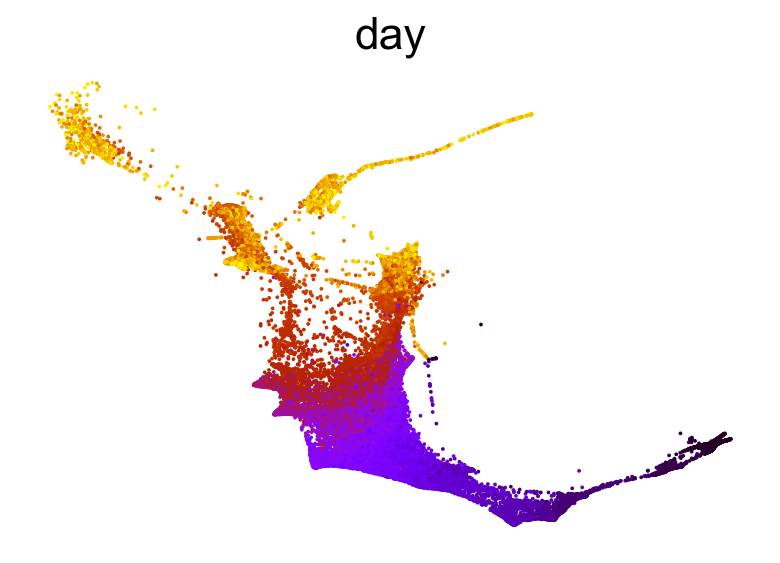

In [5]:
scv.pl.scatter(adata, basis='force_directed', c='day', legend_loc='none')

Each dot is a cell in the force-direction embedding, colored according to one of the 39 time-points of sequencing, from early (day 0, in black) to late (day 18, in yellow). 

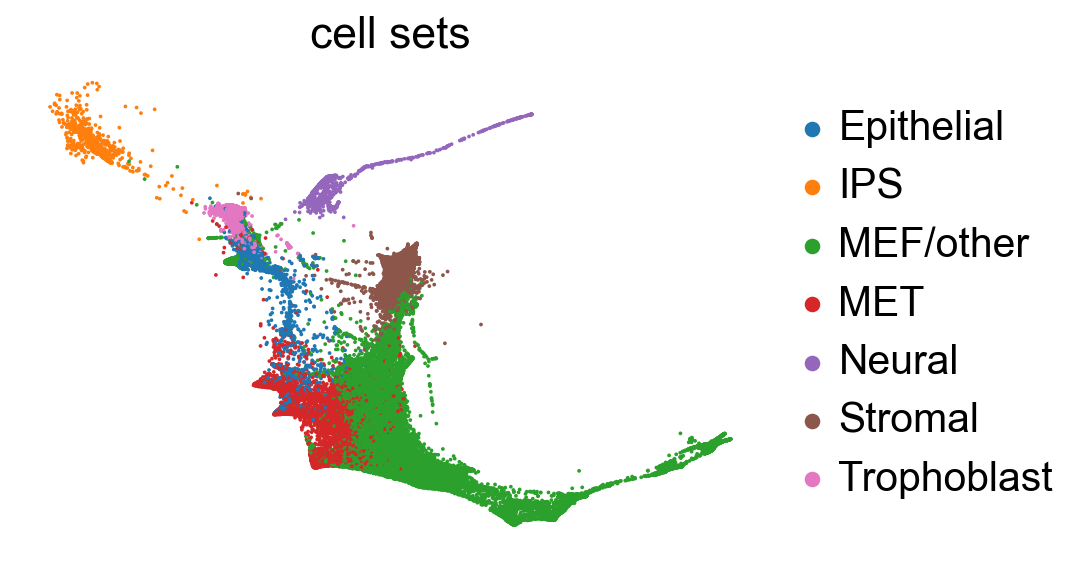

In [6]:
scv.pl.scatter(adata, basis='force_directed', c='cell_sets', legend_loc='right')

## Pre-process the data

This datset has already been normalized by total counts and log2-transformed. Further, highly variable genes have already been annotated. We can thus direclty compute PCA and a KNN graph, which we'll need for later. 

In [7]:
sc.pp.pca(adata)

In [8]:
sc.pp.neighbors(adata, random_state=0)

## Estimate initial growth rates

WOT incorporates cellular growth and death alongside differentiation. To initialze the computation of growth rates, we can use pre-compiled sets of proliferation- and apoptosis-related genes. Note that WOT uses the concept of unbalanced optimal transport which means our initial guess doesn't have to be exact - it's optimized in an iterative fashion internally. Please see the [original WOT tutorial](https://broadinstitute.github.io/wot/tutorial/) for more information on this. 

Initialize the WOT kernel based on the `AnnData` object

In [9]:
wk = WOTKernel(adata, time_key='day')

Estimate growth rates based on gene-sets for proliferation and apoptosis. 

Computing `proliferation` scores
Computing `apoptosis` scores


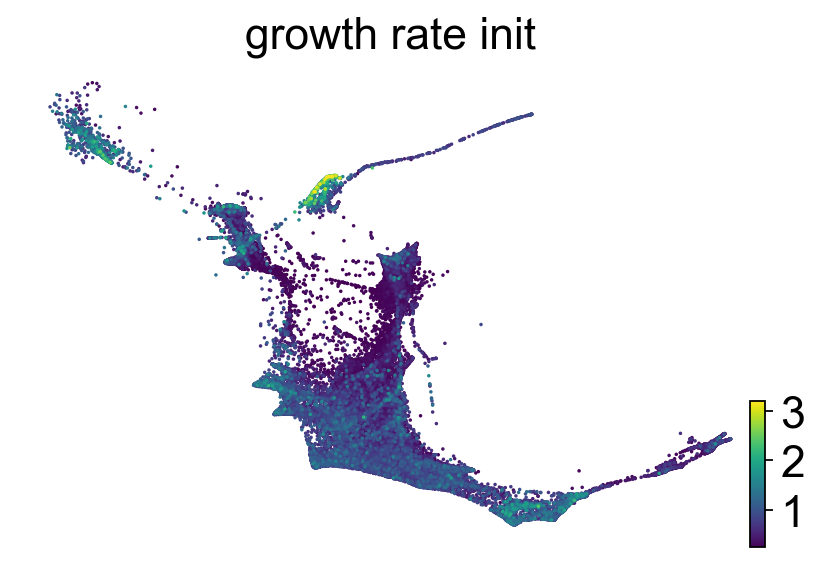

In [10]:
wk.compute_initial_growth_rates(organism='mouse', key_added='growth_rate_init')
scv.pl.scatter(adata, c='growth_rate_init', legend_loc='right', basis='force_directed', s=10)

## Compute transition matrix

During the computation of transport maps between adjacent time-points, WOT incorporates cellular growth and death. The output of the method is a list of transport maps, one for each pair of time points ($t_i, t_{i+1}$). These are saved in `wk.transport_maps`. Rows in these transport maps do not need to sum to one because depending on whether a cell is likely to proliferate or die, it's outoing probability mass will be larger or smaller than one, respectively. 

CellRank, however, is based on Markov chains where we need one single transition matrix with rows that sum to one. For this reason, in addition to the saved `transport_maps`, we accumulate the individual transport maps into one large transition matrix which we row-normalize. 

Further, for `N` time points, transition probabilities for cells in the Nth time point aren't defined since there is nowhere to transport their probability mass. However, to treat the system as a Markov chain, we need to assign transition probabilites for final-day cells as well. In this example, we'll use transcriptomic similarity for this purpose via the argument `last_time_point='connectivities'`. That means we'll compute transition probabilities for earlier day cells to later day cells using optimal transport, however, once cells have reached the last time-point, we'll compute transition probabilities among final-day cells just based on their gene expression similarity. 

In [11]:
wk.compute_transition_matrix(growth_iters=3, growth_rate_key='growth_rate_init', last_time_point='connectivities')

Computing transition matrix using Waddington optimal transport
Using `1479` HVGs from `adata.var['highly_variable']`
Using default cost matrices
Computing transport maps for `38` time pairs


    Finish (0:03:18)


Computing transition matrix based on `adata.obsp['connectivities']`
    Finish (0:00:00)
    Finish (0:03:25)


<WOTKernel>

The method argument `growth_iters` defines how many iterations we use to fine-tune the cellular growth rates. For the other parameters, see the original [WOT documentation](https://broadinstitute.github.io/wot/). 

## Simulate random walks

To gain some intuition for the transition matrix we have just computed, we can simualte some random walks and plot them in the embedding. 

Simulating `300` random walks of maximum length `200`


    Finish (0:00:25)


Plotting random walks


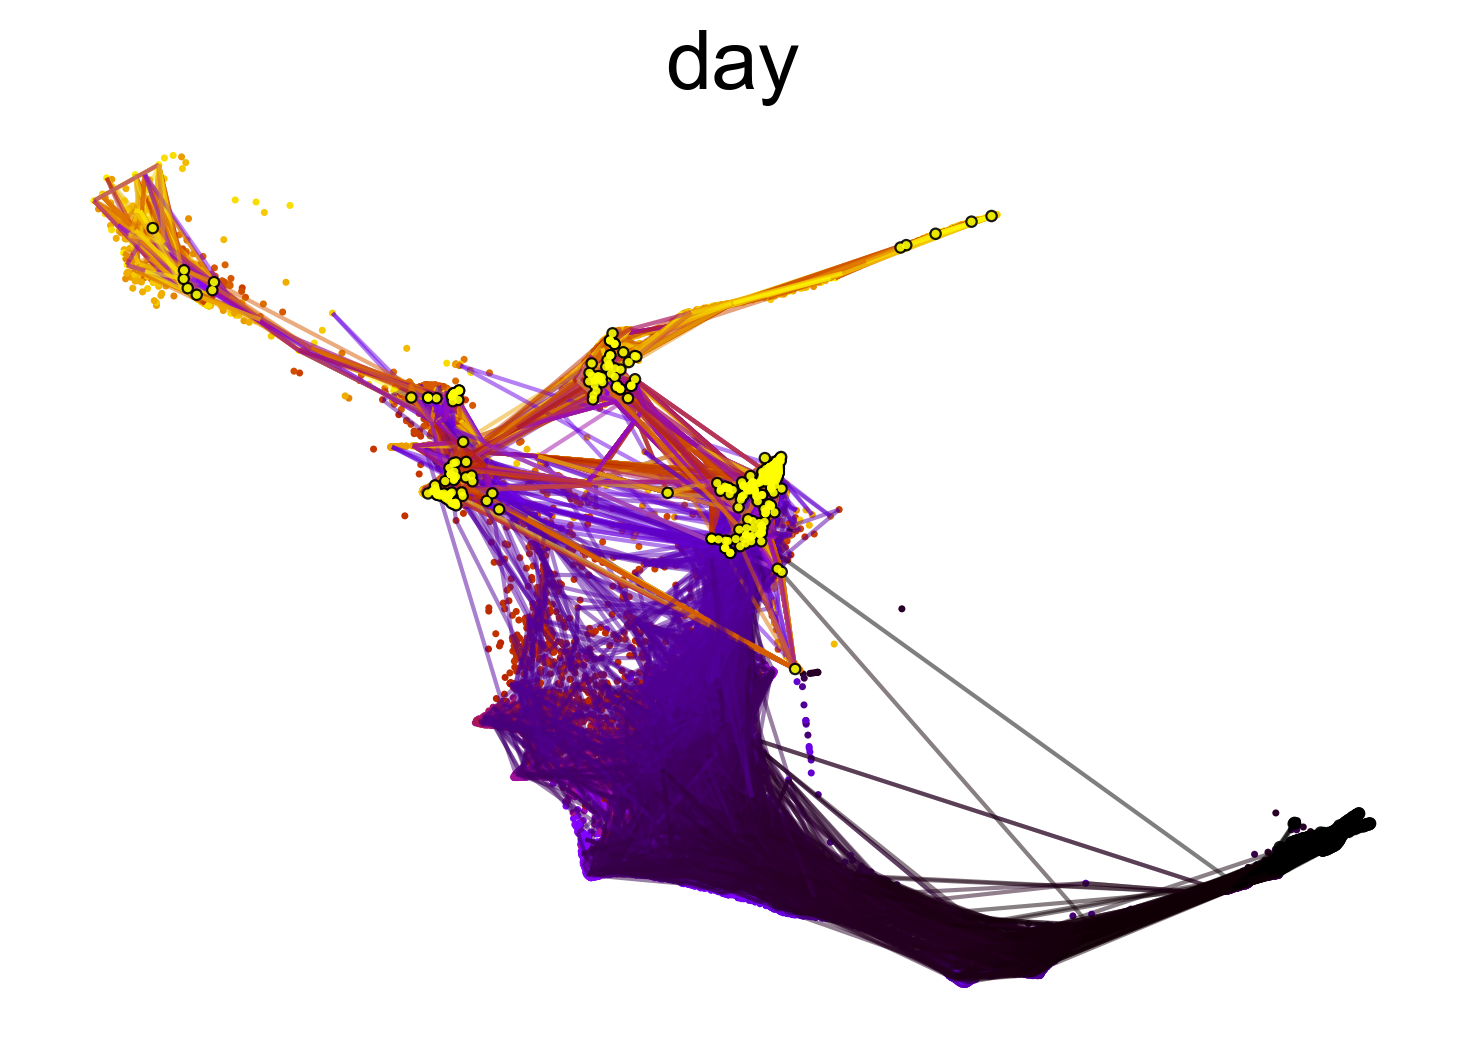

In [12]:
wk.plot_random_walks(n_sims=300, max_iter=200, start_ixs={'day': 0.0}, basis='force_directed', c='day', 
                     legend_loc="none", linealpha=0.5, dpi=150)

Black dots indicate the start of a random walk (can't really see them here, but they come from the lower right corner where day 0 MEFs are located) and yellow dots inicate the end. If we compare with the cluster labels below, we can observe that most random walks terminate in either the Trophoblast, Stromal, Epithelial, Neuronal or IPS clusters. We'll make this more quantitative below using [pyGPCCA](https://pygpcca.readthedocs.io/en/latest/) to compute macrostates. Generalized Perron Cluster Cluster Analysis (GPCCA) is a fast and mathematically sound way to define macrostates - sets of cells that have some level of metastability <cite data-cite="reuter:19">Reuter et al., JCP (2019)</cite>.

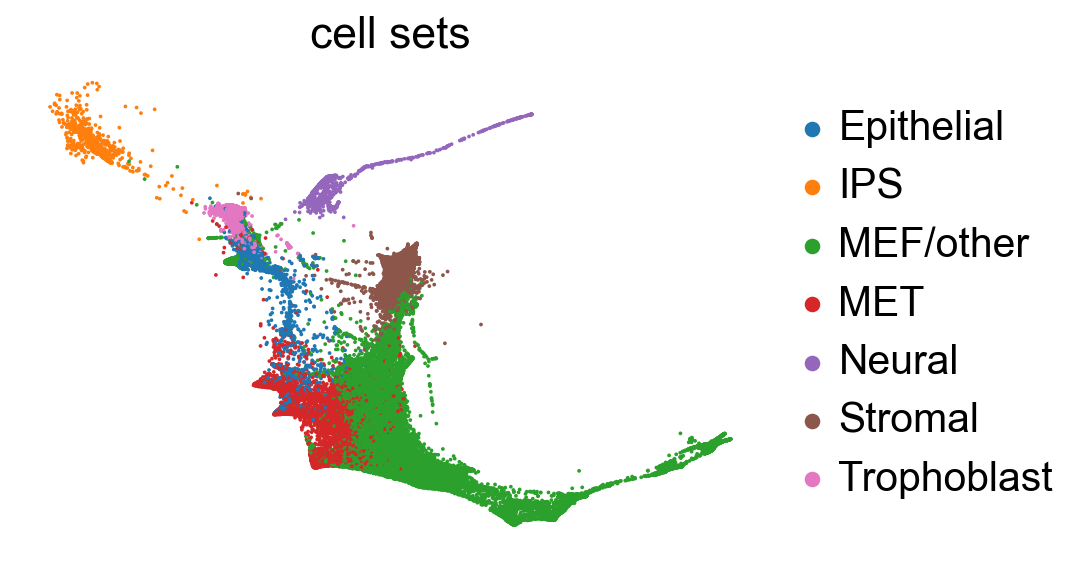

In [13]:
scv.pl.scatter(adata, c='cell_sets', basis='force_directed', legend_loc='right')

## Probability mass flow in time

Based on our transition matrix, we can check how probability mass flows from one cluster to the others as time increases. Note that this plotting function only allows one cluster to have outgoing flow. This function is a re-implementation of a similar function in R <cite data-cite="mittnenzweig:21">Mittenzweig et al., Cell 2021</cite>. 

Computing flow from `MEF/other` into `2` cluster(s) in `38` time points
Plotting flow from `MEF/other` into `2` cluster(s) in `38` time points


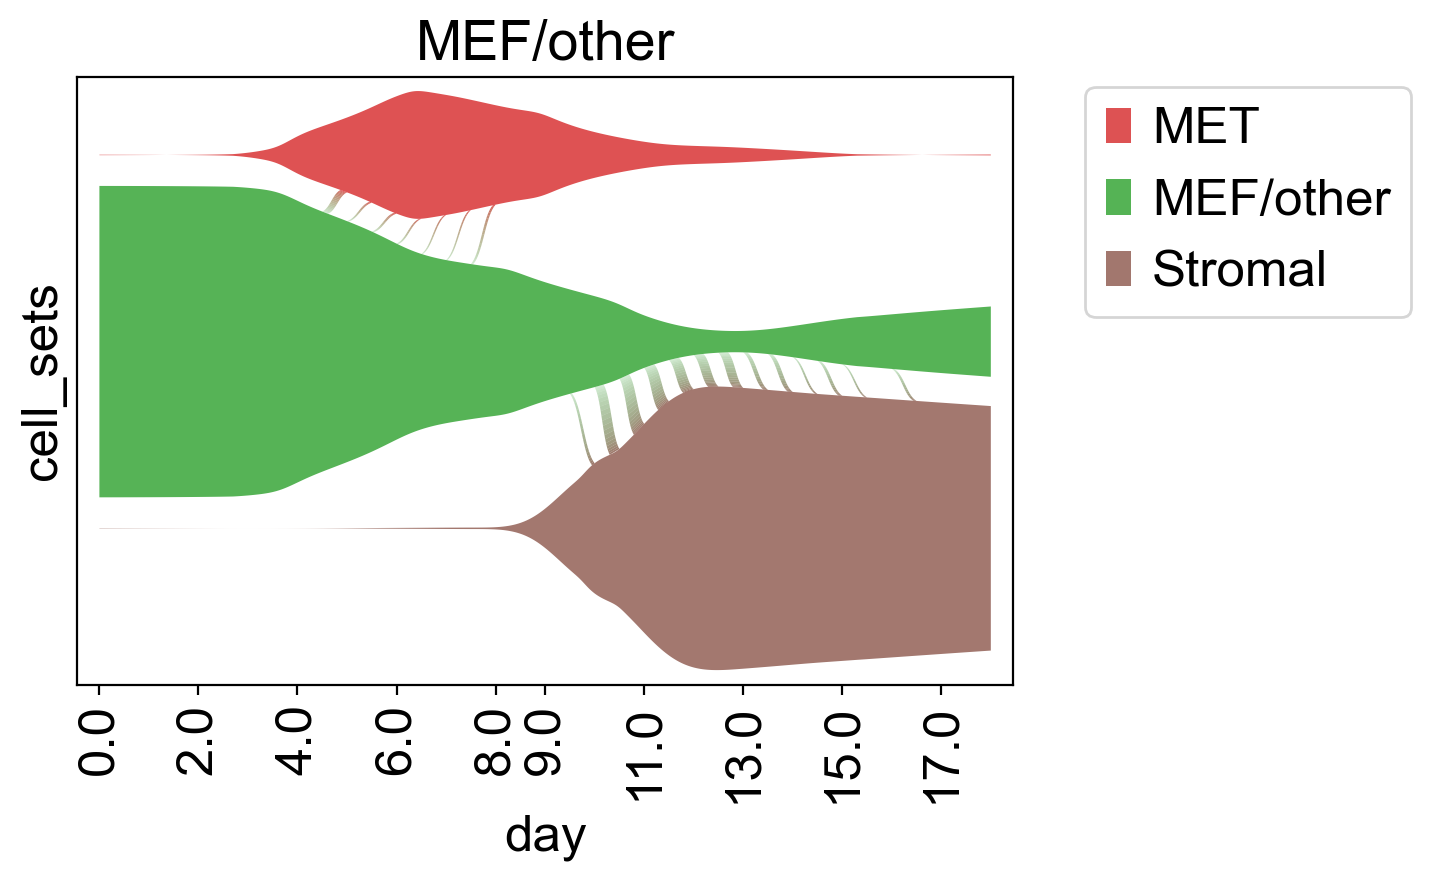

In [14]:
ax = wk.plot_single_flow(cluster_key='cell_sets', 
                         time_key='day', 
                         cluster='MEF/other', 
                         min_flow=0.1, 
                         xticks_step_size=4,
                         show=False, 
                         dpi=100,
                         clusters=['MEF/other', 'MET', 'Stromal'], 
                 )

# prettify the plot a bit, rotate x-axis tick labels
locs, labels = plt.xticks() 
ax.set_xticks(locs)
ax.set_xticklabels(labels, rotation=90)

plt.show()

This plot indicates that MEFs give rise to cells in the mesenchymal-to-epithelial (MET) transition state before populating the stromal state. 

## Compute macrostates

For numerical reasons, we'll add a connectivity kernel with small weight - this makes it much easier and numerically more stable to compute a Schur decomposition, which we need for downstream computations. 

In [15]:
ck = ConnectivityKernel(adata)
ck.compute_transition_matrix()

combined_kernel = 0.9 * wk + 0.1 * ck

Computing transition matrix based on `adata.obsp['connectivities']`
    Finish (0:00:00)


Use the combined kernel to initialise a GPCCA estimator. In CellRank, everything that performs inference based on transition matrices is called an `estimator`, see our [kernels and estimators](https://cellrank.readthedocs.io/en/stable/kernels_and_estimators.html) tutorial. 

In [16]:
g = GPCCA(combined_kernel)

Compute and plot the Schur decomposition.

Computing Schur decomposition
Adding `adata.uns['eig_fwd']`
       `.eigendecomposition`
       `.schur`
       `.schur_matrix`
    Finish (0:00:49)


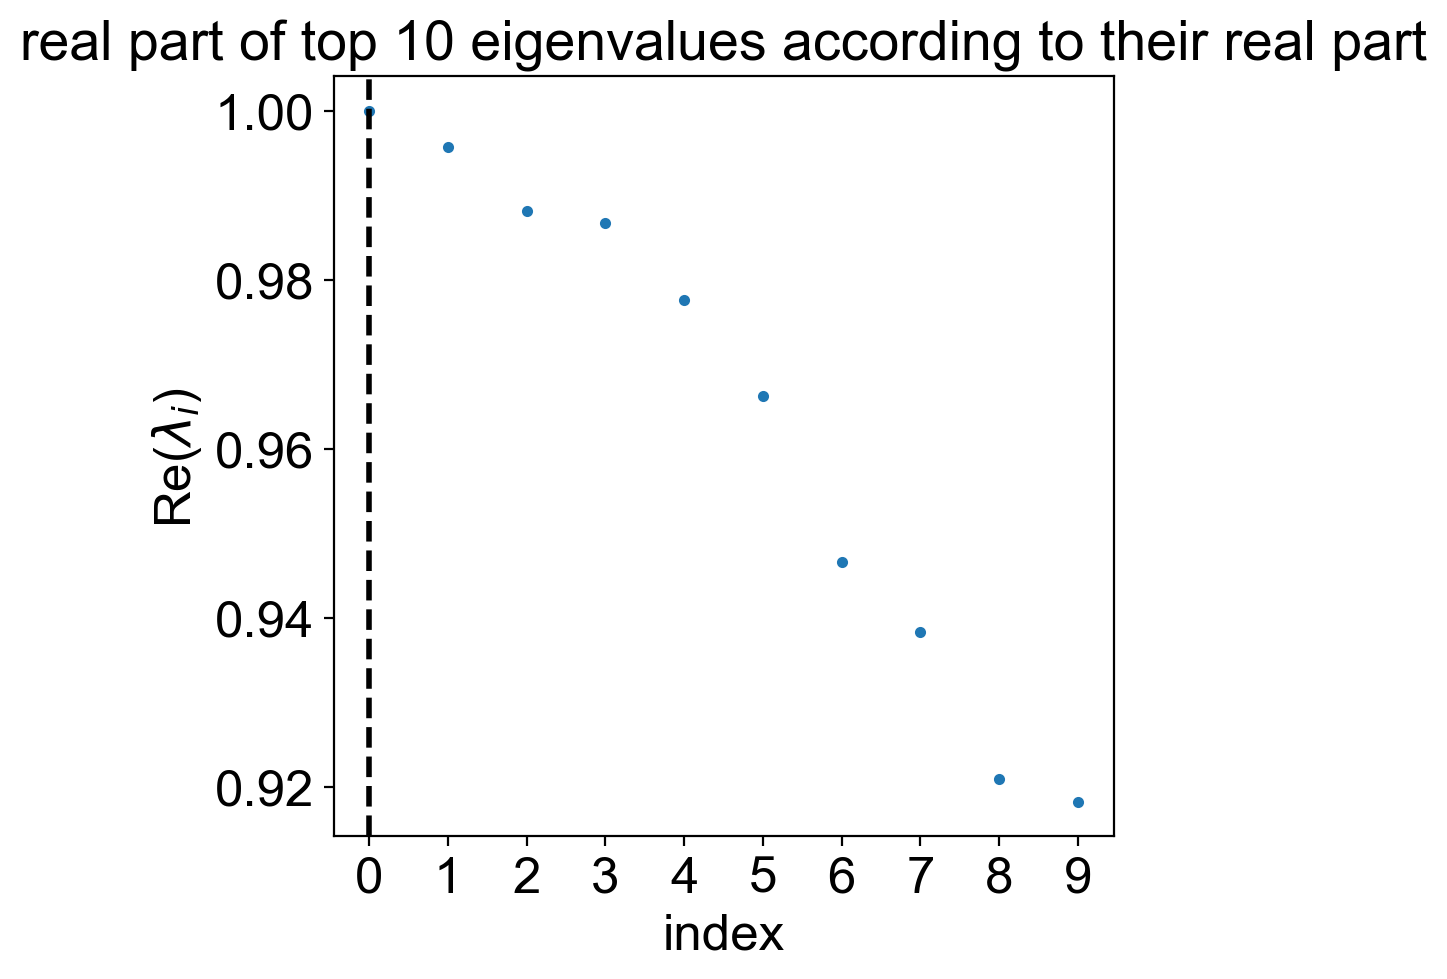

In [17]:
g.compute_schur()
g.plot_spectrum(real_only=True)

Compute 6 macrostates, show the top 30 most confidentially assigned cells per state.

Computing `6` macrostates
Adding `.macrostates_memberships`
       `.macrostates`
       `.schur`
       `.coarse_T`
       `.coarse_stationary_distribution`
    Finish (0:00:39)


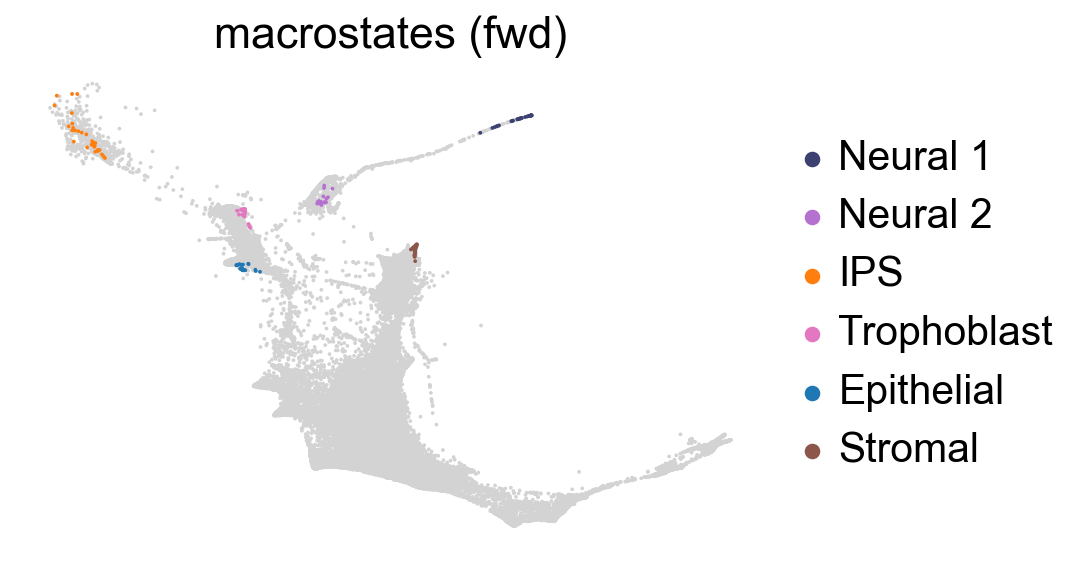

In [18]:
g.compute_macrostates(n_states=6, cluster_key='cell_sets')
g.plot_macrostates(discrete=True, basis='force_directed', legend_loc='right')

## Define terminal macrostates

To figure out which of these macrostates are terminal, check out their composition in terms of time-points. Keep in mind that we're using the top 30 cells assigned to each macrostate for this analysis. 

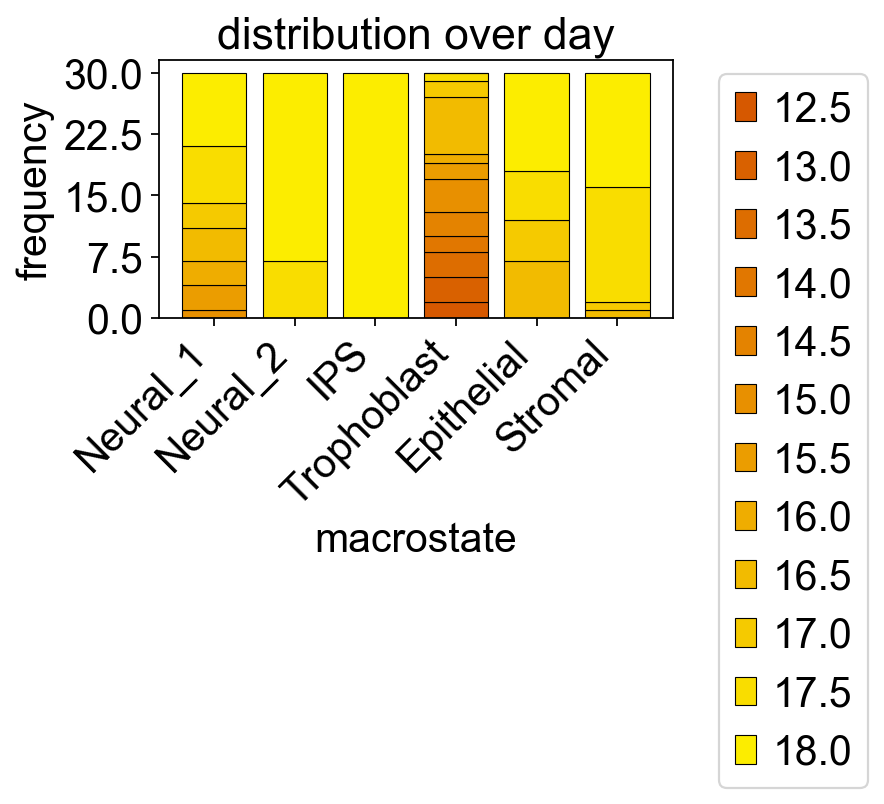

In [19]:
g.plot_macrostate_composition(key='day')

We can see that most macrostates are composed of the later days or reprogramming, i.e. days 16 and later. An exception is the "Trophoblast" state. Using this plotting function, we could equally check macrostate composition with respect to any other categorical key from `.obs`, like cluster composition. 

Below, we're manually selecting some macrostates which we think are terminal states.  

In [20]:
g.set_terminal_states_from_macrostates(['Neural_1', 'IPS', 'Trophoblast', 'Stromal'])

Adding `adata.obs['terminal_states_probs']`
       `adata.obs['terminal_states']`
       `.terminal_states_probabilities`
       `.terminal_states`
    Finish


## Compute fate probabilities

Given the terminal states, we can now compute the probability that an early cell will transition towards any of these. This shouldn't take longer than 2min on a laptop. 

In [21]:
g.compute_absorption_probabilities(solver='gmres', use_petsc=True)

Computing absorption probabilities


Adding `adata.obsm['to_terminal_states']`
       `.absorption_probabilities`
    Finish (0:01:19)


We can plot the computed fate probabilities in the force-directed embedding. 

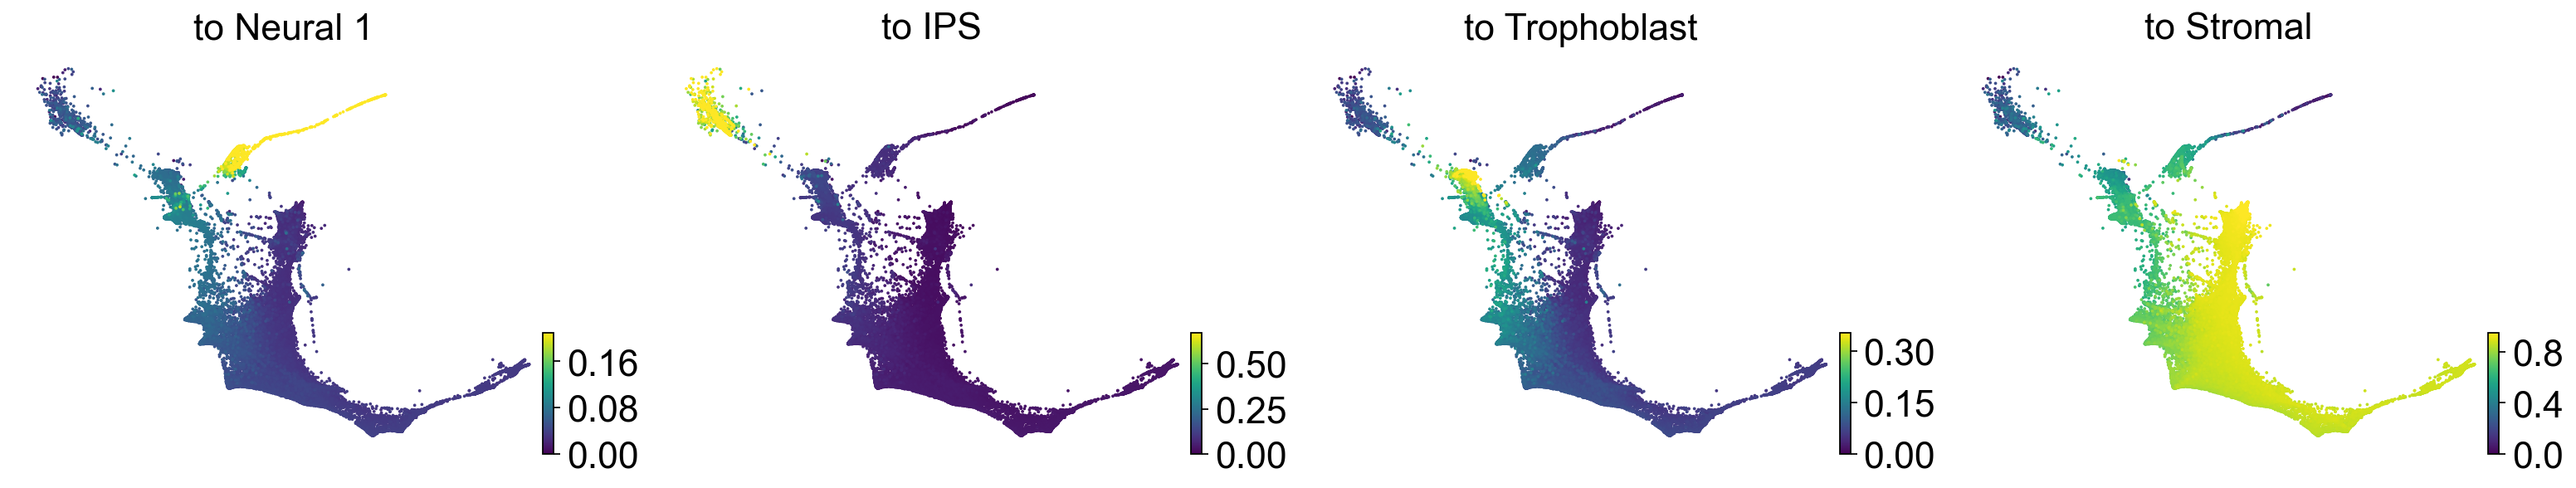

In [22]:
g.plot_absorption_probabilities(same_plot=False, basis='force_directed', perc=[0, 99])

We can summarize fate probabilities towards all terminal states in a circular embedding of the data. 

Solving TSP for `4` states


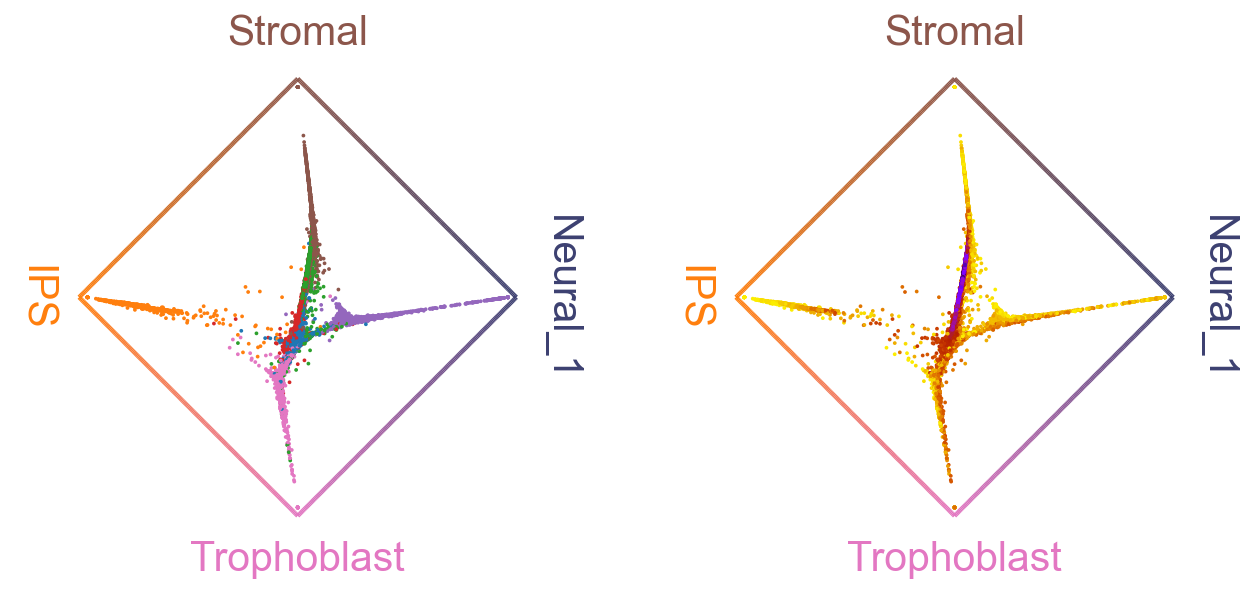

In [23]:
cr.pl.circular_projection(adata, keys=['cell_sets', 'day'], legend_loc="none", title="")

In this representation, uncommited cells are near the center and commited cells are near to one edge. Starting in the MEF cluster (green), cells first decide whether to transition towards Stromal (brown) or MET (red) fates. From the MET cluster, few cells directly transition towards the IPS fate (orange) whereas the rest moves towards Trophoblast (pink) of Neural (purple) fates via the Epithelial cluster (blue). Compare this to the time-point annotations colored in on the left. 

## Log-odds in time

We can further validate our computed fate probabilities by plotting the distribution of logg-odds for IPS vs. other fates per cell across time-points, coloring in cells that express known lineage-drivers to confirm their upregulation in the expected set of cells. 

Below, we color in *Obox6* expression, a TF that was experimentally confirmed to be involved in the reprogramming process in the original publication <cite data-cite="schiebinger:19">Schiebinger et al., Cell 2019</cite>.

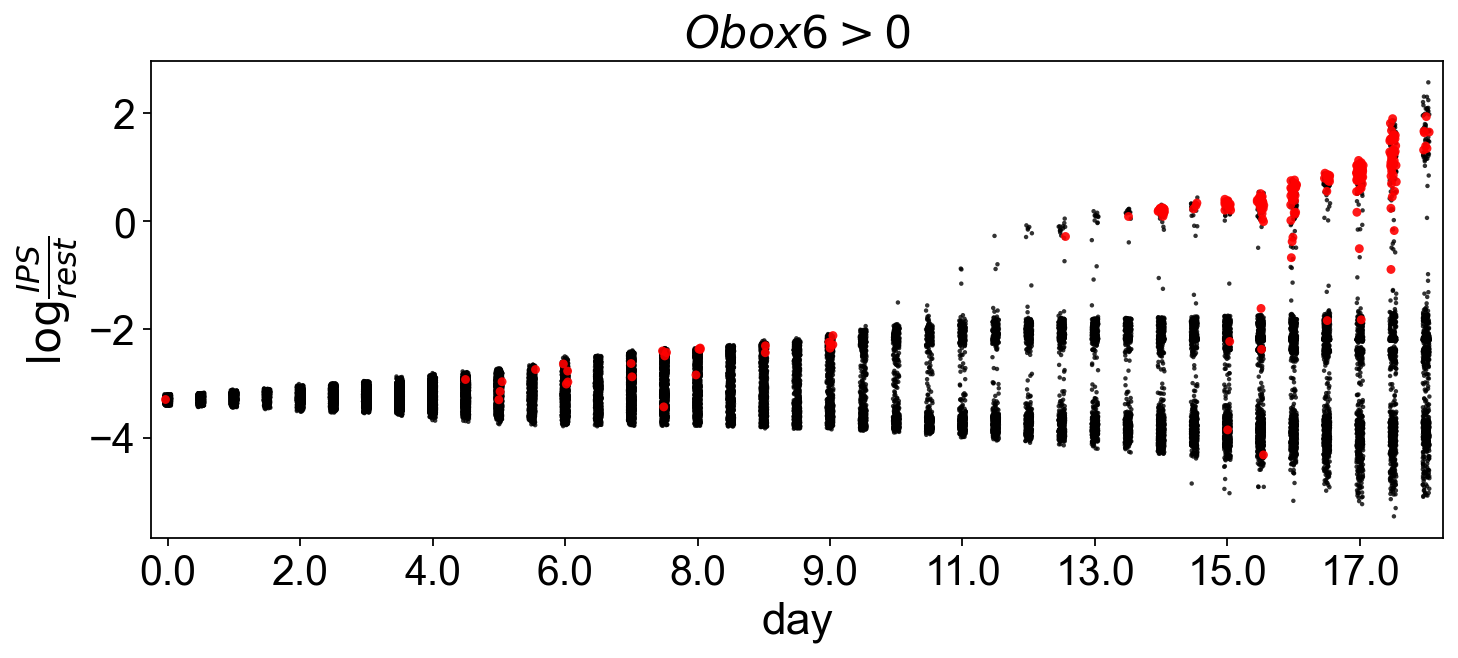

In [24]:
cr.pl.log_odds(adata, 
               lineage_1="IPS", 
               lineage_2=None, 
               time_key='day', 
               keys=['Obox6'], 
               threshold=0, 
               size=2, 
               xticks_step_size=4, 
               figsize=(9, 4))

Compare this to cluster annotations (we can pass any gene from `.var_names` or observation from `.obs` to the `keys` argument in this plotting function):

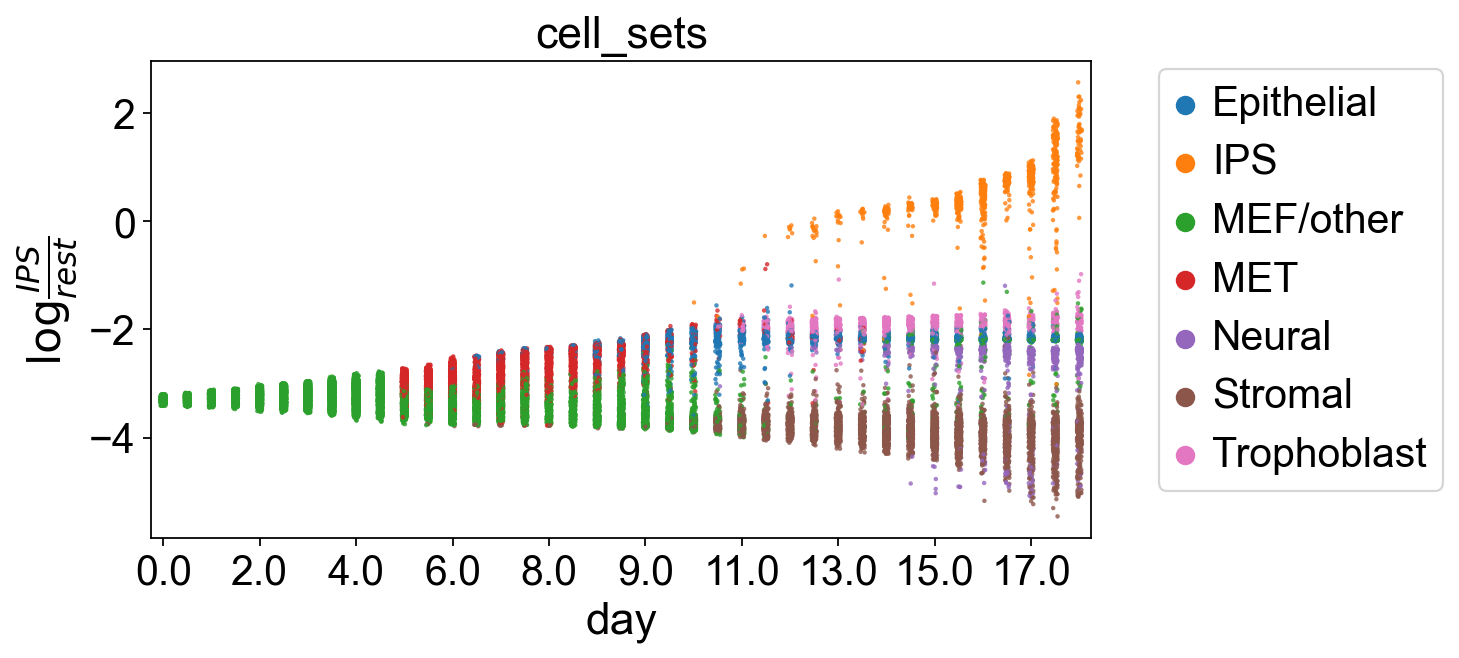

In [25]:
cr.pl.log_odds(adata, 
               lineage_1="IPS", 
               lineage_2=None, 
               time_key='day', 
               keys=['cell_sets'], 
               threshold=0, 
               size=2, 
               xticks_step_size=4, 
               figsize=(9, 4), 
               legend_loc='upper right out')

This makes sense - as expected, *Obox6* positive cells have a high probability to differentiate towards the IPS terminal state, and the IPS precursor cells emberge from the MET region <cite data-cite="schiebinger:19">Schiebinger et al., Cell 2019</cite>.

## Driver genes

Lastly, we would like to learn something about genes which could be involved in this process - putative "lineage drivers". We do this by correlating gene expression with fate probabilities below. 

In [26]:
g.compute_lineage_drivers(return_drivers=False)

Computing correlations for lineages `['Neural_1' 'IPS' 'Trophoblast' 'Stromal']` restricted to clusters `None` in layer `X` with `use_raw=False`
Adding `.lineage_drivers`
       `adata.var['to Neural_1 corr']`
       `adata.var['to IPS corr']`
       `adata.var['to Trophoblast corr']`
       `adata.var['to Stromal corr']`
    Finish (0:00:06)


We'll look at the trophoblast vs. neural lineages here and plot their fate correlations in a scatter plot. We'll annotate some genes that have been found to be lineage-correlated in the original publication. 

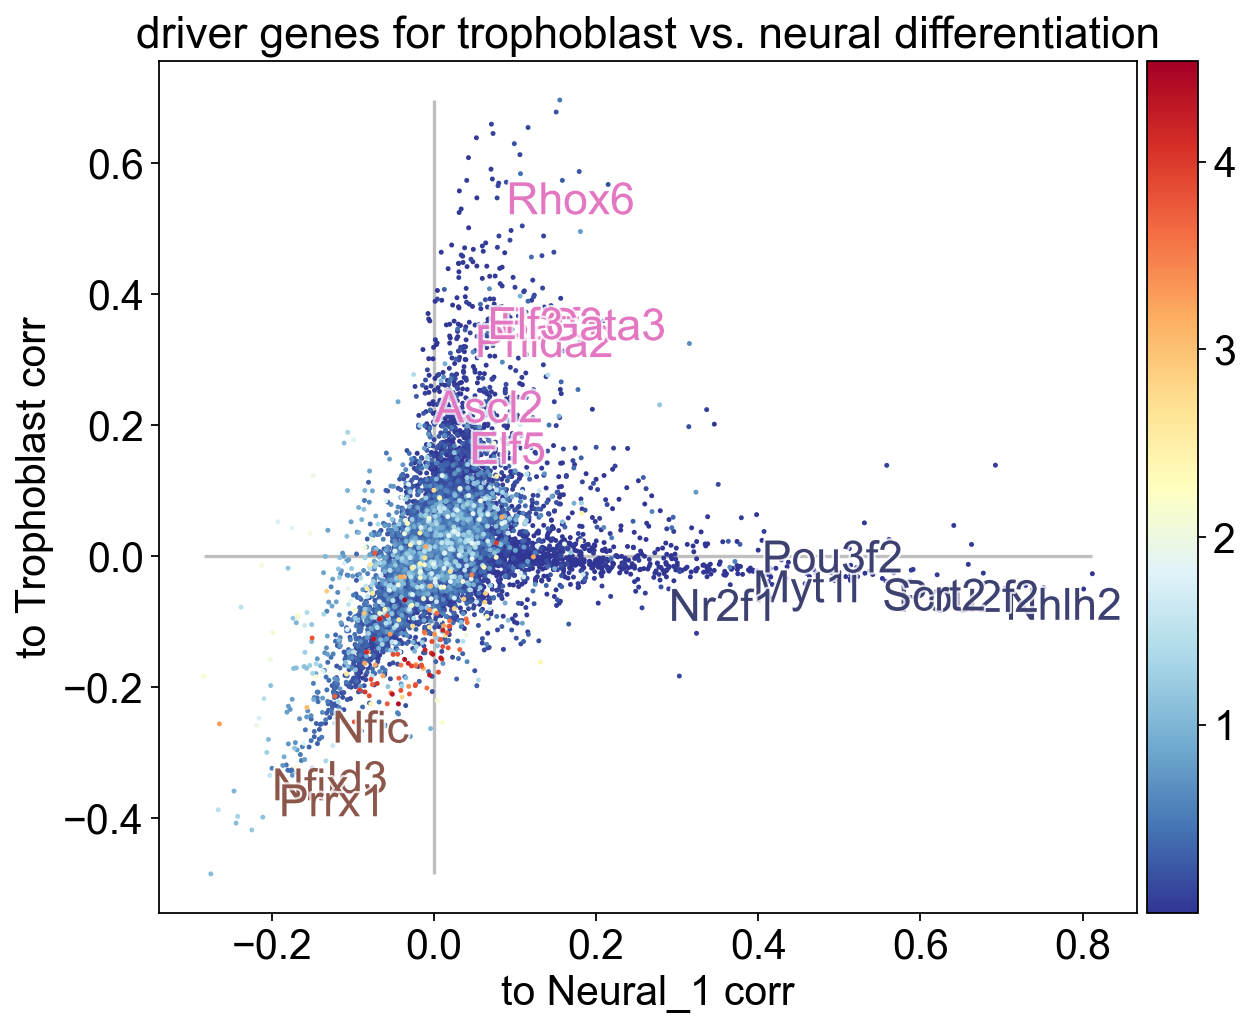

In [27]:
# define some gene sets
trophoblast_genes = ['Gata3', 'Elf5', 'Ascl2', 'Phlda2', 'Rhox6', 
                     'Batf3', 'Elf3']
neural_genes = ['Pou3f2', 'Nr2f1', 'Myt1l', 'Scrt2', 'Nhlh2', 'Pou2f2']
stromal_genes = ['Id3', 'Nfix', 'Nfic', 'Prrx1']
genes_oi = {'Neural_1': neural_genes,
            'Trophoblast': trophoblast_genes,
            'Stromal': stromal_genes}

# compute mean gene expression across cells, so we have somethign nice to color the dots by
adata.var['means'] = adata.X.A.mean(axis=0)

# call the actual plotting method via the estimator object
g.plot_lineage_drivers_correlation(lineage_x='Neural_1', 
                                   lineage_y='Trophoblast', 
                                   color='means', 
                                   gene_sets=genes_oi, 
                                   legend_loc='none', 
                                   figsize=(7, 7),
                                   fontsize=20,
                                   title='driver genes for trophoblast vs. neural differentiation',
                                   size=20)

Genes are colored according to the lineage we expect them to correlate with, i.e. Trophoblast in pink, Neural in dark blue and stromal in brown. As expected, Neural (Trophoblast) genes correlate well with Neural (Trophoblast) fate probabilities, and both Neural and Trophoblast fate probabilities are correlated negatively with stromal genes. 

## What's next?

- try this out on your own data. Open an [issue](https://github.com/theislab/cellrank/issues/new/choose) if something is unclear or does not work for you.
- we welcome any contributions to CellRank. Please check out our [contributing guide](https://github.com/theislab/cellrank/blob/master/CONTRIBUTING.rst).
- if you don't have time-points in your data, try our [CytoTRACEKernel](https://cellrank.readthedocs.io/en/stable/beyond_rna_velocity.html) or [PseudotimeKernel](https://cellrank.readthedocs.io/en/stable/api/cellrank.tl.kernels.PseudotimeKernel.html).
- If you are wondering how several kernels can be combined, take a look at our [Kernels and estimators tutorial](https://cellrank.readthedocs.io/en/stable/kernels_and_estimators.html). You could e.g. combine RNA velocity with real-time information. 
- in particular, if you have a method that computes a transition matrix from single-cell data in a way not yet covered by CellRank, consider providing an interface to your method by writing a `kernel` class. It is very simple and we explain it in our [Creating a new kernel tutorial](https://cellrank.readthedocs.io/en/stable/creating_new_kernel.html). 